In [1]:
import astropy
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ICRS
from astropy.time import Time
from astropy.constants import c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

Converting AltAz to RA DEC and finding the radial velocity correction

In [17]:
alt = 57.66 * u.deg  # Altitude
az = 179.99 * u.deg   # Azimuth

green_bank = EarthLocation(lat=38.4330 * u.deg, lon=-79.8397 * u.deg, height=800 * u.m)
jodrell_bank = EarthLocation(lat=53.234329 * u.deg, lon=-2.3050403 * u.deg, height=77 * u.m)

obstime = Time('2024-07-18T09:50:54')

altaz = AltAz(alt=alt, az=az, location=jodrell_bank, obstime=obstime)

skycoord = SkyCoord(altaz)

ra = skycoord.icrs.ra
dec = skycoord.icrs.dec

print(ra.deg,dec.deg)

ra_str = ra.to_string(unit=u.hour, sep=':', pad=True)
dec_str = dec.to_string(unit=u.deg, sep=':', pad=True)

print(f'RA: {ra_str}')
print(f'Dec: {dec_str}')

bary_corr = (skycoord.transform_to(ICRS)).radial_velocity_correction(kind='heliocentric')
barry_corr = bary_corr.to(u.km/u.s)

#print radial velocity correction for barycentre
print(f'Radial Velocity correction to barycentre: {barry_corr}')

81.76574635181774 20.873053993789906
RA: 05:27:03.7791
Dec: 20:52:22.9944
Radial Velocity correction to barycentre: 16.30662787874121 km / s


Comparing Shinichiro's data with LAB data, exploring how beamwidth and elevation accuracy affect the profile

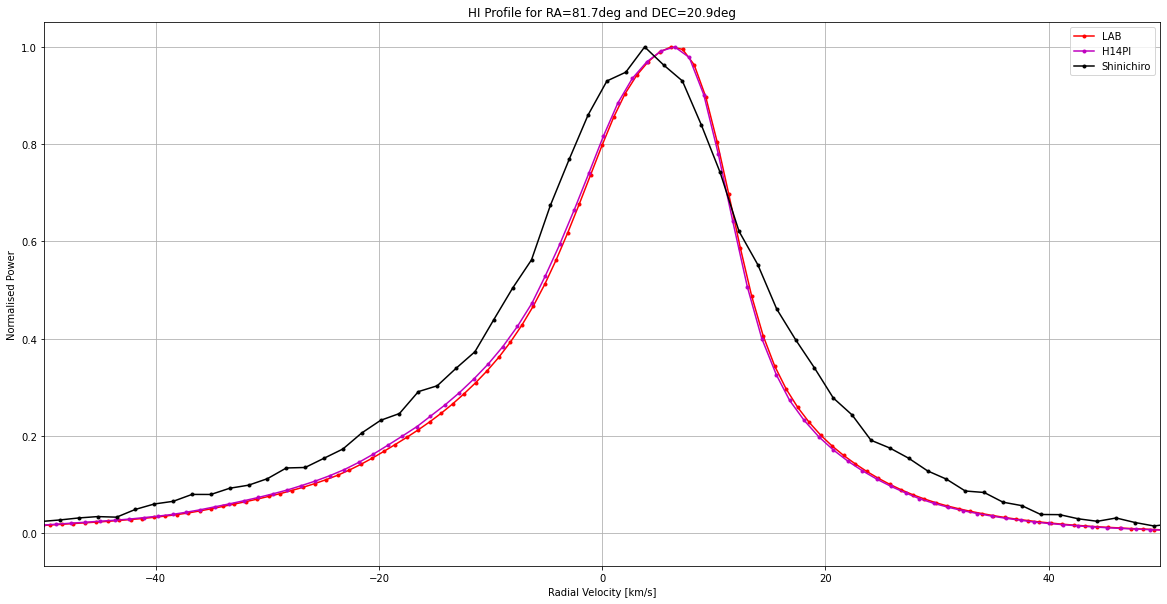

Difference between peak positions: [2.375] [2.695] km/s
Resolution of LAB, Shinichiro, H14PI data: 1.0304896907216496 1.69 1.2881974248927037
[1.74600919]


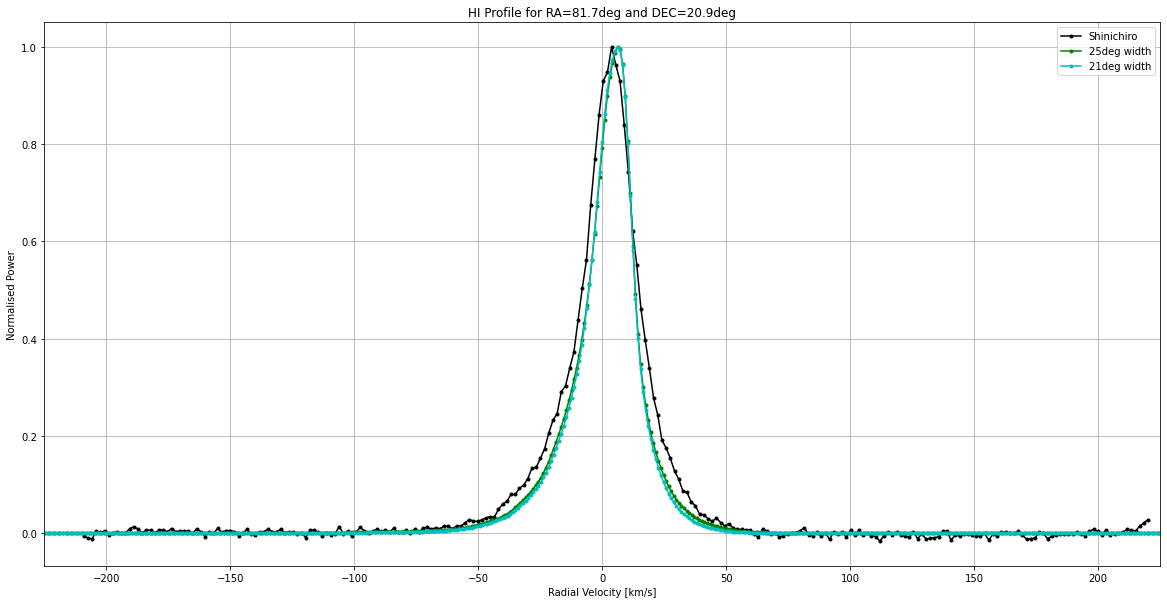

Difference between peak positions (21deg): [2.375] km/s
Difference between peak positions (25deg): [2.375] km/s


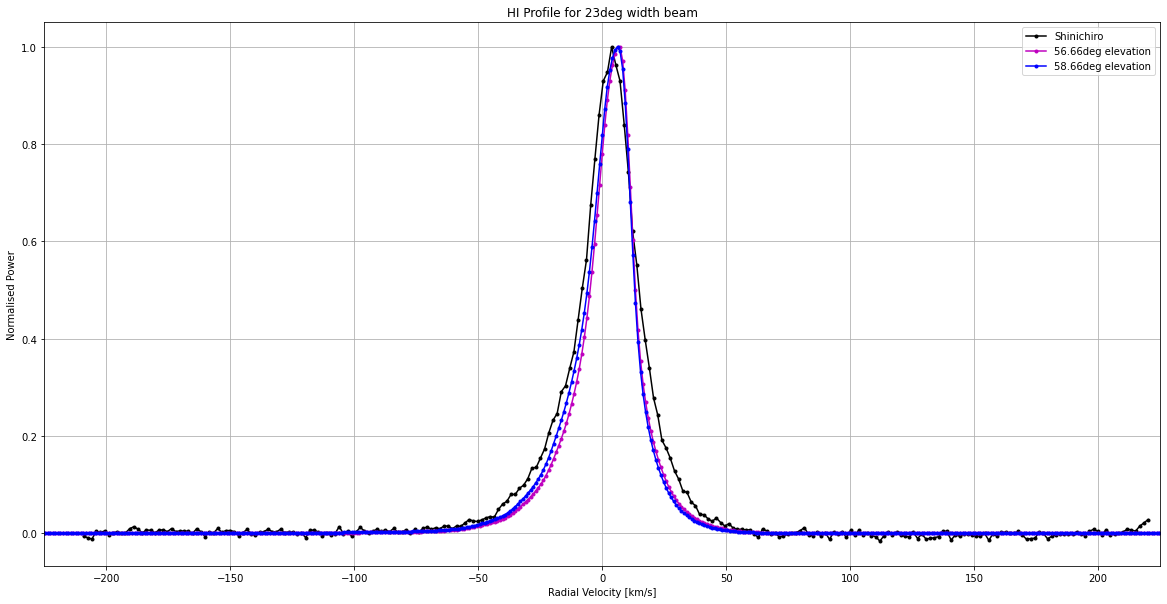

Difference between peak positions (58.66deg): [2.375] km/s
Difference between peak positions (56.66deg): [2.375] km/s


In [26]:
lab_data = np.genfromtxt("spectrum 23deg 57.66el.txt", skip_header=4)
sc_data = np.genfromtxt("20240718T105054_Vlsr.xlsx - 20240718T105054.csv", skip_header=1, delimiter=',')

deg25_data = np.genfromtxt("spectrum 25deg 57.66el.txt", skip_header=4)
deg21_data = np.genfromtxt("spectrum 21deg 57.66el.txt", skip_header=4)
el56_data = np.genfromtxt("spectrum 23deg 56.66el.txt", skip_header=4)
el58_data = np.genfromtxt("spectrum 23deg 58.66el.txt", skip_header=4)

lab_vel = lab_data[:,0]
lab_pwr = lab_data[:,1] / np.max(lab_data[:,1])
sc_vel = sc_data[0:255,3]
sc_pwr = sc_data[0:255,8]

deg25_vel = deg25_data[:,0]
deg25_pwr = deg25_data[:,1] / np.max(deg25_data[:,1])
deg21_vel = deg21_data[:,0]
deg21_pwr = deg21_data[:,1] / np.max(deg21_data[:,1])
el56_vel = el56_data[:,0]
el56_pwr = el56_data[:,1] / np.max(el56_data[:,1])
el58_vel = el58_data[:,0]
el58_pwr = el58_data[:,1] / np.max(el58_data[:,1])

h14pi_data = np.genfromtxt("spectra h14pi 57.66el.csv", skip_header=2, delimiter=',')
h14pi_vel = h14pi_data[:,0]
h14pi_23deg_pwr = h14pi_data[:,1] / np.max(h14pi_data[:,1])
h14pi_10deg_pwr = h14pi_data[:,2] / np.max(h14pi_data[:,2])

plt.figure(figsize=(20, 10))
plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel , h14pi_23deg_pwr, marker=".", color='m', label="H14PI")
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for RA=81.7deg and DEC=20.9deg")
plt.xlim(-50,50)
plt.show()

lab_pk = lab_vel[np.where(lab_pwr == np.max(lab_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
h14pi_pk = h14pi_vel[np.where(h14pi_23deg_pwr == np.max(h14pi_23deg_pwr))]
pk_dif_1 = lab_pk-sc_pk
pk_dif_2 = h14pi_pk-sc_pk
print("Difference between peak positions:", pk_dif_1, pk_dif_2, "km/s")

lab_res = np.abs(np.sum(np.diff(lab_vel))/(len(lab_vel)-1))
sc_res = np.abs(np.sum(np.diff(sc_vel))/(len(sc_vel)-1))
h14pi_res = np.abs(np.sum(np.diff(h14pi_vel))/(len(h14pi_vel)-1))
print("Resolution of LAB, Shinichiro, H14PI data:", lab_res, sc_res, h14pi_res)

print(pk_dif_1/((lab_res/2)+(sc_res/2)))

plt.figure(figsize=(20, 10))
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.plot(deg25_vel, deg25_pwr, marker=".", color='g', label="25deg width")
plt.plot(deg21_vel, deg21_pwr, marker=".", color='c', label="21deg width")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for RA=81.7deg and DEC=20.9deg")
plt.xlim(-225,225)
plt.show()

deg25_pk = deg25_vel[np.where(deg25_pwr == np.max(deg25_pwr))]
deg21_pk = deg21_vel[np.where(deg21_pwr == np.max(deg21_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
deg25_pk_dif = deg25_pk-sc_pk
deg21_pk_dif = deg25_pk-sc_pk
print("Difference between peak positions (21deg):", deg21_pk_dif, "km/s")
print("Difference between peak positions (25deg):", deg25_pk_dif, "km/s")

plt.figure(figsize=(20, 10))
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.plot(el56_vel, el56_pwr, marker=".", color='m', label="56.66deg elevation")
plt.plot(el58_vel, el58_pwr, marker=".", color='b', label="58.66deg elevation")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 23deg width beam")
plt.xlim(-225,225)
plt.show()

el56_pk = el56_vel[np.where(el56_pwr == np.max(el56_pwr))]
el58_pk = el58_vel[np.where(el58_pwr == np.max(el58_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
el56_pk_dif = el56_pk-sc_pk
el58_pk_dif = el58_pk-sc_pk
print("Difference between peak positions (58.66deg):", el58_pk_dif, "km/s")
print("Difference between peak positions (56.66deg):", el56_pk_dif, "km/s")



Comparing LAB data convolved to different beam sizes

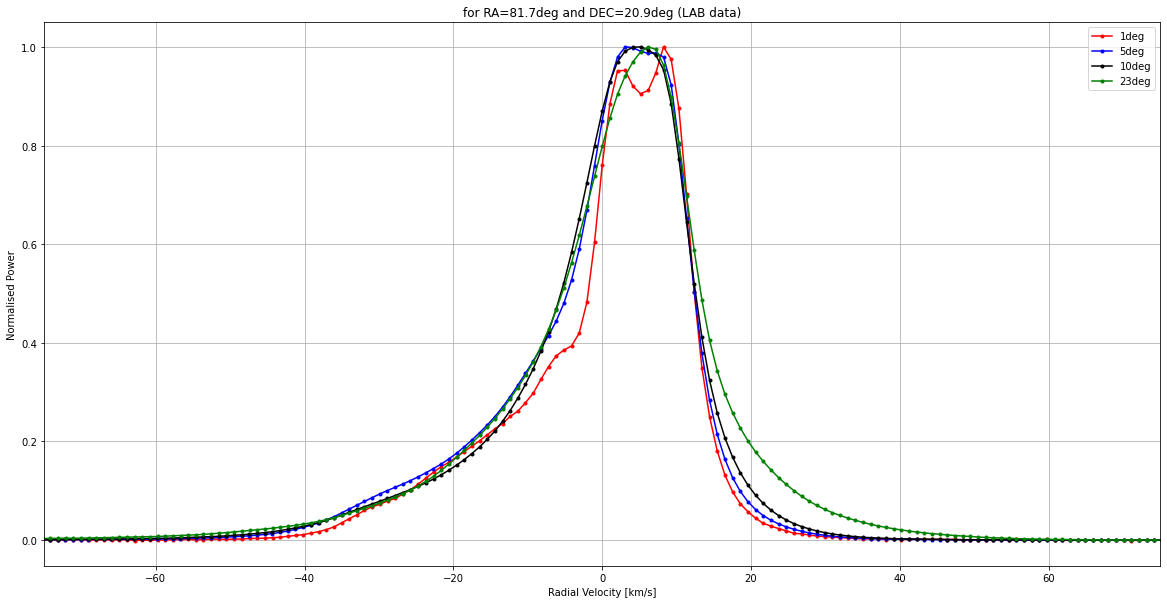

[8.24] [3.09] [5.15] [6.18]


In [23]:
deg1_data = np.genfromtxt("spectrum 1deg 57.66el.txt", skip_header=4)
deg5_data = np.genfromtxt("spectrum 5deg 57.66el.txt", skip_header=4)
deg10_data = np.genfromtxt("spectrum 10deg 57.66el.txt", skip_header=4)

deg1_vel = deg1_data[:,0]
deg1_pwr = deg1_data[:,1] / np.max(deg1_data[:,1])
deg5_vel = deg5_data[:,0]
deg5_pwr = deg5_data[:,1] / np.max(deg5_data[:,1])
deg10_vel = deg10_data[:,0]
deg10_pwr = deg10_data[:,1] / np.max(deg10_data[:,1])

plt.figure(figsize=(20, 10))
plt.plot(deg1_vel, deg1_pwr, marker=".", color='r', label="1deg")
plt.plot(deg5_vel, deg5_pwr, marker=".", color='b', label="5deg")
plt.plot(deg10_vel, deg10_pwr, marker=".", color='k', label="10deg")
plt.plot(lab_vel, lab_pwr, marker=".", color='g', label="23deg")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("for RA=81.7deg and DEC=20.9deg (LAB data)")
plt.xlim(-75,75)
plt.show()

deg1_pk = deg1_vel[np.where(deg1_pwr == np.max(deg1_pwr))]
deg5_pk = deg5_vel[np.where(deg5_pwr == np.max(deg5_pwr))]
deg10_pk = deg10_vel[np.where(deg10_pwr == np.max(deg10_pwr))]

print(deg1_pk, deg5_pk, deg10_pk, lab_pk)

Comparing LAB and H14PI data convolved to different beam sizes

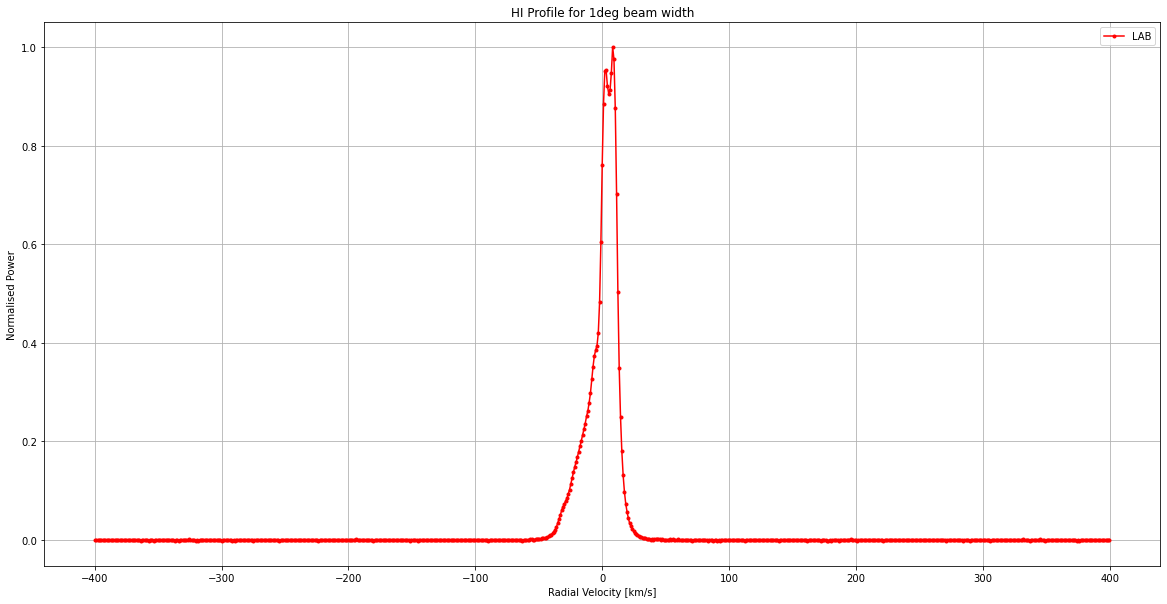

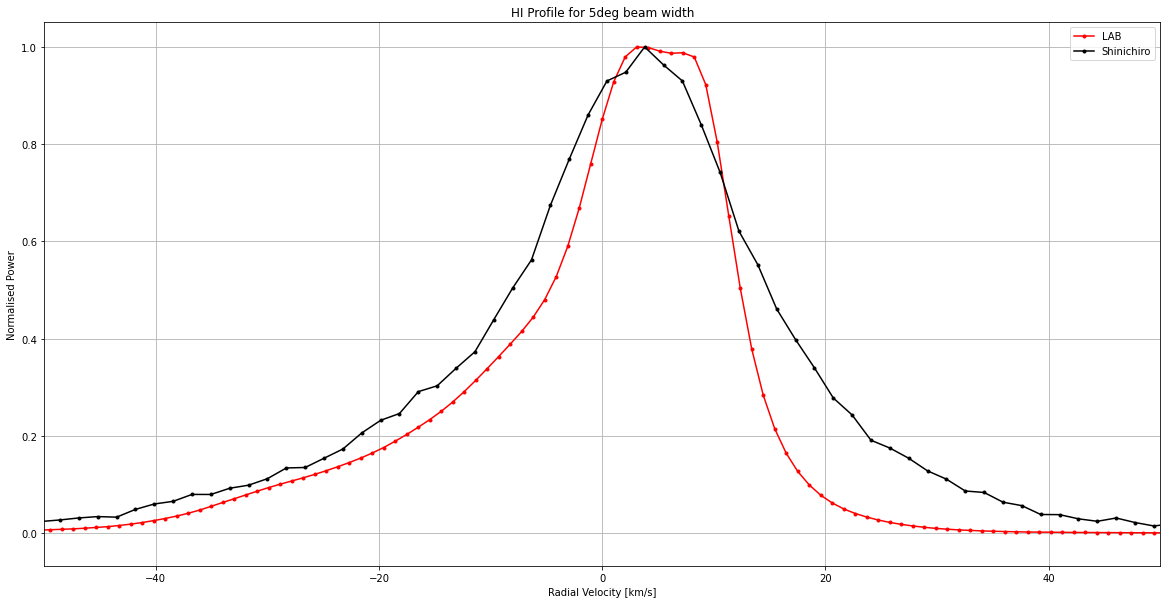

[-0.715]


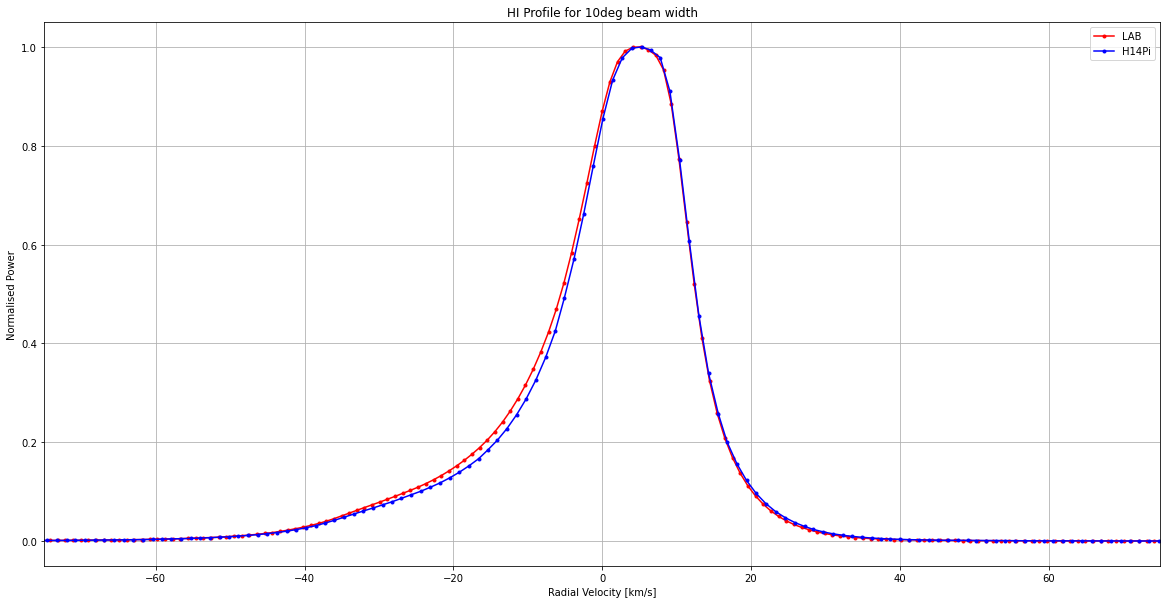

[0.15]


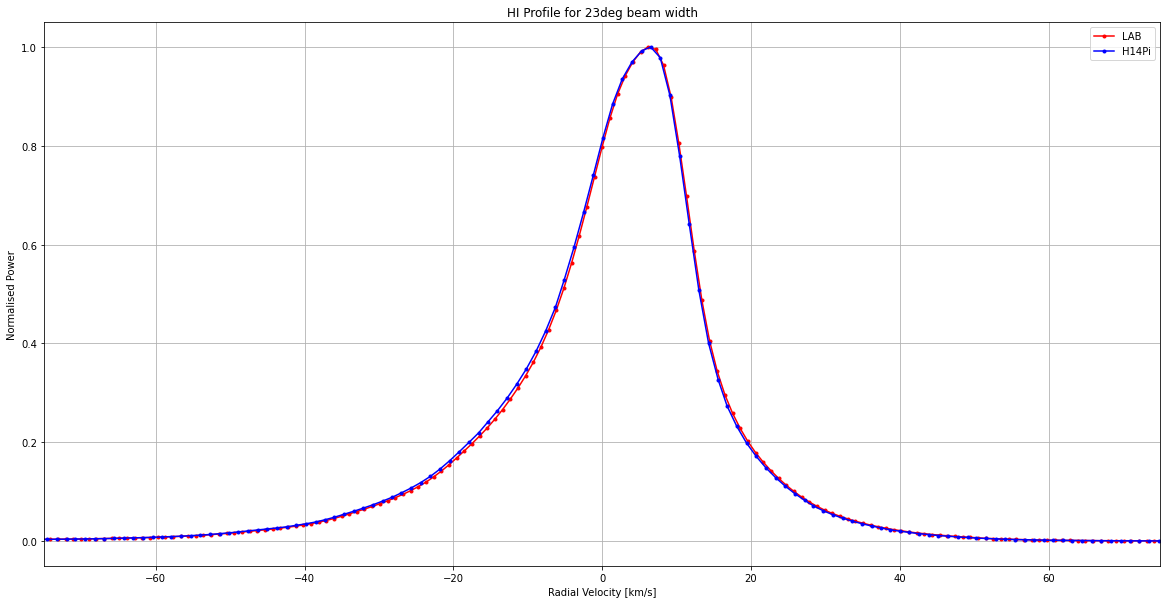

[0.32]


In [27]:
plt.figure(figsize=(20, 10))
plt.plot(deg1_vel, deg1_pwr, marker=".", color='r', label="LAB")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 1deg beam width")
plt.show()

plt.figure(figsize=(20, 10)) 
plt.plot(deg5_vel, deg5_pwr, marker=".", color='r', label="LAB")
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 5deg beam width")
plt.xlim(-50, 50)
plt.show()

print(deg5_pk-sc_pk)

plt.figure(figsize=(20, 10))
plt.plot(deg10_vel, deg10_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel, h14pi_10deg_pwr, marker=".", color='b', label="H14Pi")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 10deg beam width")
plt.xlim(-75,75)
plt.show()

h14pi_deg10_pk = h14pi_vel[np.where(h14pi_10deg_pwr == np.max(h14pi_10deg_pwr))]
print(h14pi_deg10_pk-deg10_pk)

plt.figure(figsize=(20, 10))
plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel, h14pi_23deg_pwr, marker=".", color='b', label="H14Pi")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 23deg beam width")
plt.xlim(-75,75)
plt.show()

print(h14pi_pk-lab_pk)

deg1_pk = deg1_vel[np.where(deg1_pwr == np.max(deg1_pwr))]
deg5_pk = deg5_vel[np.where(deg5_pwr == np.max(deg5_pwr))]
deg10_pk = deg10_vel[np.where(deg10_pwr == np.max(deg10_pwr))]

LSR https://www.researchgate.net/publication/227646452_Local_Kinematics_and_the_Local_Standard_of_Rest

In [6]:
print("LSR:", np.sqrt(11.1**2 + 12.24**2 + 7.25**2))
print("+/-", np.sqrt((0.74/11.1)**2 + (0.47/12.24)**2 + (0.37/7.25)**2))

LSR: 18.044115384246467
+/- 0.09232238344213324
